# Importing Libraries

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd
import re
from keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

## Preprocessing

In [3]:
imdb_df = pd.read_csv(r"C:\Users\liuru\Desktop\EE6405\Data\IMDB\IMDB Dataset.csv")
df_positive = imdb_df[imdb_df['sentiment']=='positive'][:5000]
df_negative = imdb_df[imdb_df['sentiment']=='negative'][:5000]
imdb = pd.concat([df_positive,df_negative ])
imdb.shape

(10000, 2)

In [4]:
# remove "(<.*?>)" markup
imdb['review'] = imdb['review'].apply(lambda x: re.sub('(<.*?>)', ' ', x))
# remove punctuation marks 
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
# remove whitespace
imdb['review'] = imdb['review'].apply(lambda x: x.strip())
# remove all strings that contain a non-letter
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[^a-zA-Z"]',' ',x))
# convert to lower
imdb['review'] = imdb['review'].apply(lambda x: x.lower())

In [5]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liuru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liuru\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None
def tagged_lemma(string):
    
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

In [7]:
imdb['review']=imdb['review'].apply(tagged_lemma)
print(imdb['review'][3])

basically there s a family where a little boy jake think there s a zombie in his closet his parent be fight all the time this movie be slow than a soap opera and suddenly jake decides to become rambo and kill the zombie ok first of all when you re go to make a film you must decide if its a thriller or a drama as a drama the movie be watchable parent be divorce argue like in real life and then we have jake with his closet which totally ruin all the film i expect to see a boogeyman similar movie and instead i watch a drama with some meaningless thriller spot out of just for the well play parent descent dialog as for the shot with jake just ignore them


In [8]:
words = imdb['review'].apply(lambda x: text_to_word_sequence(x))
stop_words = set(stopwords.words('english'))
filtered_words = words.apply(lambda x: [w for w in x if not w in stop_words])
imdb['review'] = filtered_words.apply(lambda x: " ".join(x))
imdb['review'][3]

'basically family little boy jake think zombie closet parent fight time movie slow soap opera suddenly jake decides become rambo kill zombie ok first go make film must decide thriller drama drama movie watchable parent divorce argue like real life jake closet totally ruin film expect see boogeyman similar movie instead watch drama meaningless thriller spot well play parent descent dialog shot jake ignore'

In [9]:
imdb.sentiment = imdb.sentiment.apply(lambda x: 1 if x=='positive' else 0)

In [10]:
from sklearn.model_selection import train_test_split
train_review, test_review, train_sent, test_sent = train_test_split(imdb['review'], imdb['sentiment'], test_size=0.25, random_state=42)

In [11]:
#Tfidf vectorizer
tv=TfidfVectorizer(stop_words='english')
#transformed train reviews
train_review_tfidf=np.asarray(tv.fit_transform(train_review).todense())
#transformed test reviews
test_review_tfidf=np.asarray(tv.transform(test_review).todense())
print('Tfidf_train:',train_review_tfidf.shape)
print('Tfidf_test:',test_review_tfidf.shape)

Tfidf_train: (7500, 42076)
Tfidf_test: (2500, 42076)


In [12]:
print(train_review_tfidf[3].shape)

(42076,)


## SVM Model

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
#generates a confusion matrix between hand labelled data and model predictions
def getConfMatrix(pred_data, actual):
    conf_mat = confusion_matrix(actual, pred_data, labels=[0,1])
    accuracy = accuracy_score(actual, pred_data)
    precision = precision_score(actual, pred_data, average='micro')
    recall = recall_score(actual, pred_data, average='micro')
    sns.heatmap(conf_mat, annot = True, fmt=".0f", annot_kws={"size": 18})
    print('Accuracy: '+ str(accuracy))
    print('Precision: '+ str(precision))
    print('Recall: '+ str(recall))

In [16]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # RBF kernel

#Train the model using the training sets
clf.fit(train_review_tfidf, train_sent)

#Predict the response for test dataset
y_pred = clf.predict(test_review_tfidf)

## Confusion Matrix

Accuracy: 0.872
Precision: 0.872
Recall: 0.872


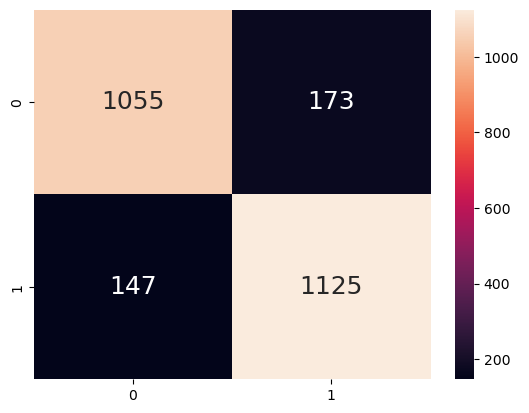

In [17]:
getConfMatrix(y_pred,test_sent)

In [19]:
from sklearn.metrics import f1_score
micro = f1_score(test_sent, y_pred, average='micro') 
macro = f1_score(test_sent,y_pred, average='macro')
print('F1 Micro: '+ str(micro))
print('F1 Macro: '+ str(macro))

F1 Micro: 0.872
F1 Macro: 0.8718995692623017


## AUC-ROC

A logistic regression model is used here as AUC-ROC requires a probabilistic model.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(train_review_tfidf, train_sent)

LogisticRegression()

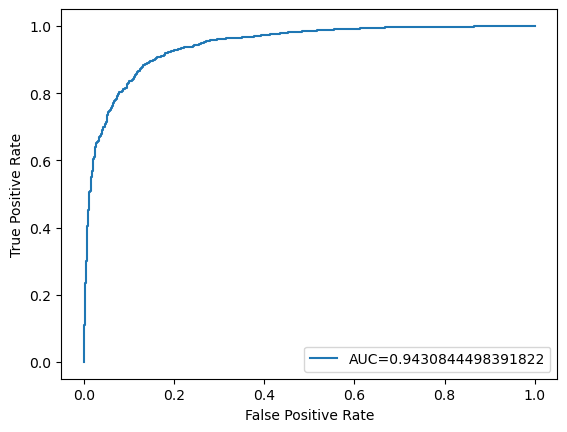

In [25]:
#define metrics
y_pred_proba = log_regression.predict_proba(test_review_tfidf)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_sent,  y_pred_proba)
auc = metrics.roc_auc_score(test_sent, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## BLEU Score

In [25]:
import nltk
from nltk import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
ref = 'The guard arrived late because it was raining.'
cand = 'The guard arrived late because of the rain.'
smoothie = SmoothingFunction().method1
reference = word_tokenize(ref)
candidate = word_tokenize(cand)
weights = (0.25, 0.25, 0.25, 0.25)
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], candidate, weights, smoothing_function=smoothie)
print(BLEUscore)

0.4671379777282001


## ROUGE

In [1]:
import evaluate
rouge = evaluate.load('rouge')
predictions = ["Transformers Transformers are fast plus efficient", 
               "Good Morning", "I am waiting for new Transformers"]
references = [
              ["HuggingFace Transformers are fast efficient plus awesome", 
               "Transformers are awesome because they are fast to execute"], 
              ["Good Morning Transformers", "Morning Transformers"], 
              ["People are eagerly waiting for new Transformer models", 
               "People are very excited about new Transformers"]

]
results = rouge.compute(predictions=predictions, references=references)
print(results)

C:\Users\liuru\anaconda3\envs\tensorflow_base\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'rouge1': 0.6659340659340659, 'rouge2': 0.45454545454545453, 'rougeL': 0.6146520146520146, 'rougeLsum': 0.6146520146520146}


## METEOR

In [3]:
from nltk.translate import meteor
from nltk import word_tokenize
score=round(meteor([word_tokenize('The cat sat on the mat')],
                   word_tokenize('The cat was sat on the mat')), 4)
print('The METEOR score is: '+str(score))

The METEOR score is: 0.9654


In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Sample sentences for training Word2Vec
sentences = [
    "Word2Vec is a technique for word embedding.",
    "Embedding words in vector space is powerful for NLP.",
    "Gensim provides an easy way to work with Word2Vec.",
]

# Tokenize the sentences into words
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

# Train a Word2Vec model
model = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1, sg=0)  
# Adjust parameters as needed

# Save the trained model for future use
model.save("word2vec.model")

# Load the model (if needed)
# model = Word2Vec.load("word2vec.model")

# Get the word embeddings
word = "word"
if word in model.wv:
    embedding = model.wv[word]
    print(f"Embedding for '{word}': {embedding}")
else:
    print(f"'{word}' is not in the vocabulary.")

# Similarity between words
similarity = model.wv.similarity("word", "embedding")
print(f"Similarity between 'word' and 'embedding': {similarity}")

Embedding for 'word': [-9.5782708e-03  8.9433035e-03  4.1655651e-03  9.2360200e-03
  6.6434164e-03  2.9238823e-03  9.8045552e-03 -4.4228774e-03
 -6.8031684e-03  4.2263791e-03  3.7309569e-03 -5.6647998e-03
  9.7051831e-03 -3.5571249e-03  9.5494138e-03  8.3399686e-04
 -6.3375360e-03 -1.9765303e-03 -7.3783435e-03 -2.9803123e-03
  1.0425968e-03  9.4828764e-03  9.3571255e-03 -6.5945145e-03
  3.4750504e-03  2.2753996e-03 -2.4888995e-03 -9.2287343e-03
  1.0264782e-03 -8.1667695e-03  6.3202251e-03 -5.8006351e-03
  5.5357707e-03  9.8335072e-03 -1.6020649e-04  4.5292759e-03
 -1.8079536e-03  7.3599042e-03  3.9389166e-03 -9.0105701e-03
 -2.3983277e-03  3.6285119e-03 -9.9961828e-05 -1.2015507e-03
 -1.0550468e-03 -1.6715144e-03  6.0320512e-04  4.1645542e-03
 -4.2527826e-03 -3.8329726e-03 -5.2653751e-05  2.6851249e-04
 -1.7041666e-04 -4.7857561e-03  4.3126042e-03 -2.1723476e-03
  2.1040821e-03  6.6577346e-04  5.9687104e-03 -6.8427366e-03
 -6.8160188e-03 -4.4750450e-03  9.4369482e-03 -1.5926627e-03
 -

## GloVe

In [5]:
import gensim.downloader as api

# Load the pre-trained GloVe model (you may need to download it first)
glove_model = api.load("glove-wiki-gigaword-100")

# Find the embedding for a specific word
word = "nero"
try:
    embedding = glove_model[word]
    print(f"Embedding for '{word}':")
    print(embedding)
except KeyError:
    print(f"'{word}' is not in the vocabulary.")

# Find the most similar words to a given word
similar_words = glove_model.most_similar(word)
print(f"\nWords most similar to '{word}':")
for similar_word, score in similar_words:
    print(similar_word, score)

Embedding for 'nero':
[ 0.12703   -1.2517    -0.30333   -0.24548    0.068448   1.1062
  0.30107   -0.33641    0.067003  -0.71713   -0.045462   0.38737
 -0.53082    0.19166   -0.13454   -0.69842    0.43061   -0.1036
  0.33654    0.74012    0.026213  -0.52291   -0.3713     1.0698
  0.61742    0.27974    0.66584   -0.11241    0.0066852  0.1599
  0.16144    0.29823   -0.079172   0.1576     0.20478    1.1741
  0.24823   -0.60665    0.83795    0.44143   -0.31444    0.0040575
  0.19608    0.36953    0.16881   -0.081036  -0.23726   -0.82465
 -0.025315   0.44143   -0.18847    0.2841     0.034934   0.41033
 -0.73196   -0.41349   -0.72422    0.31519   -1.13      -0.2272
  0.080723   0.50456    0.014441   0.14606   -0.15919   -0.54273
 -0.43092   -0.37986   -0.35882   -0.037606   0.51308   -0.2918
  0.46491    0.41077   -0.20835   -1.2477    -0.77411    0.053342
 -0.57954    0.58317    0.56071   -0.16284   -0.3974     0.77043
 -0.58452    0.7157    -0.89662   -0.60718   -0.26547    0.11487
  0.482